# Homework

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Q1

Read the data for January. How many records are there?

In [2]:
file = "../data/fhv_tripdata_2021-01.parquet"
df = pd.read_parquet(file)
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [3]:
len(df)

1154112

## Q2

What's the average trip duration in January?

In [4]:
df["duration"] = df["dropOff_datetime"] - df["pickup_datetime"]
df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

In [5]:
df["duration"].describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

Distribution of the duration variable:

/home/avillalbacantero/miniconda3/envs/mlops_zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Duration (min)')

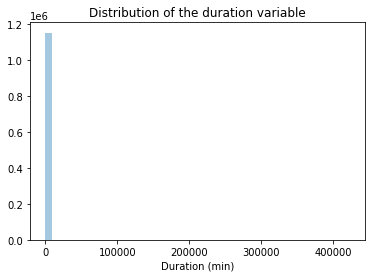

In [7]:
plt.figure()
sns.distplot(a=df["duration"], kde=False)
plt.title("Distribution of the duration variable")
plt.xlabel("Duration (min)")

There are some outliers, we remove them:

In [8]:
cleaned_df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

In [9]:
len(df) - len(cleaned_df)

44286

Text(0.5, 0, 'Duration (min)')

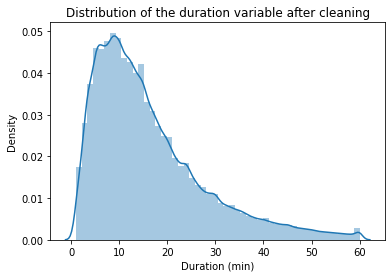

In [10]:
plt.figure()
sns.distplot(a=cleaned_df["duration"], kde=True)
plt.title("Distribution of the duration variable after cleaning")
plt.xlabel("Duration (min)")

## Q3:

What's the fractions of missing values for the pickup location ID?

In [11]:
num_nan_samples = len(cleaned_df[cleaned_df["PUlocationID"].isna()])

In [12]:
prop = num_nan_samples / len(cleaned_df)
prop * 100.0

83.52732770722618

Fill NaNs for pickup and dropoff location IDs with -1:

In [13]:
values = {"PUlocationID": -1, "DOlocationID": -1}
cleaned_df = cleaned_df.fillna(value=values)

cleaned_df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,None,B00037,9.050000


In [14]:
cleaned_df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [15]:
cleaned_df["PUlocationID"] = cleaned_df["PUlocationID"].astype(int)
cleaned_df["DOlocationID"] = cleaned_df["DOlocationID"].astype(int)

In [16]:
cleaned_df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                       int64
DOlocationID                       int64
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

## Q4: 

What's the dimensionality of the feature matrix?

In [17]:
# Convert categorical cols to str before computing the feature matrix
cleaned_df["PUlocationID"] = cleaned_df["PUlocationID"].astype(str)
cleaned_df["DOlocationID"] = cleaned_df["DOlocationID"].astype(str)

In [18]:
cleaned_df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [19]:
features_to_keep = ["PUlocationID", "DOlocationID"]
data_dicts = cleaned_df[features_to_keep].to_dict(orient='records')

In [20]:
dv = DictVectorizer()
X_train = dv.fit_transform(data_dicts)

In [21]:
X_train.shape

(1109826, 525)

## Q5

What's the RMSE on the train data after training a linear regression?

In [22]:
Y_train = cleaned_df["duration"].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [24]:
Y_train_pred = lr.predict(X_train)

In [25]:
rmse = mean_squared_error(Y_train, Y_train_pred, squared=False)
rmse

10.528519425310185

## Q6

What's the RMSE on validation?

In [26]:
file = "../data/fhv_tripdata_2021-02.parquet"
val_df = pd.read_parquet(file)

In [27]:
val_df["duration"] = val_df["dropOff_datetime"] - val_df["pickup_datetime"]
val_df["duration"] = val_df["duration"].apply(lambda td: td.total_seconds() / 60)

In [28]:
cleaned_val_df = val_df[(val_df["duration"] >= 1) & (val_df["duration"] <= 60)]

In [29]:
values = {"PUlocationID": -1, "DOlocationID": -1}
cleaned_val_df = cleaned_val_df.fillna(value=values)

In [32]:
cleaned_val_df["PUlocationID"] = cleaned_val_df["PUlocationID"].astype(int)
cleaned_val_df["DOlocationID"] = cleaned_val_df["DOlocationID"].astype(int)

In [33]:
cleaned_val_df["PUlocationID"] = cleaned_val_df["PUlocationID"].astype(str)
cleaned_val_df["DOlocationID"] = cleaned_val_df["DOlocationID"].astype(str)

In [34]:
cleaned_val_df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [35]:
val_data_dicts = cleaned_val_df[features_to_keep].to_dict(orient='records')
X_val = dv.transform(val_data_dicts)

In [36]:
Y_val = cleaned_val_df["duration"].values

In [37]:
Y_val_pred = lr.predict(X_val)

In [38]:
val_rmse = mean_squared_error(Y_val, Y_val_pred, squared=False)
val_rmse

11.014285828610237